In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

c:\Users\joeag\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
class Layer(nn.Module):
    def __init__(self, size, prev_size=None, step_size=0.1, func=F.sigmoid, lateral=True):
        super(Layer, self).__init__()
        self.size = size
        self.prev_size = prev_size
        self.first_layer = prev_size is None
        self.step_size = step_size
        self.func = func

        if not self.first_layer:
            self.bottom_up = torch.sigmoid(torch.randn(self.size, self.prev_size))
            self.top_down = torch.sigmoid(torch.randn(self.prev_size, self.size))

        if lateral:
            self.lateral = torch.sigmoid(torch.randn(self.size, self.size))
        else:
            self.lateral = None

    def init_state(self, batch_size=1):
        if not self.first_layer:
            self.belief = torch.randn(batch_size, self.size)
        self.error = torch.randn(batch_size, self.size)

    def get_prediction(self):
        if self.first_layer:
            raise Exception("First layer has no prediction")
        return self.func(F.linear(self.belief, self.top_down))

    def forward(self, inp, pred=None): # inp is obs if first layer, else is error from layer below
        if self.first_layer:
            self.belief = inp
        else:
            b_update = F.linear(inp, self.bottom_up)
            self.belief -= self.step_size * (b_update + self.error)

        if pred is None:
            pred = torch.randn(self.size)
        self.error = self.belief - pred 
        if self.lateral is not None:
            self.error -= F.linear(self.error, self.lateral)
        

In [75]:
class Network(nn.Module):
    def __init__(self, sizes, steps=20):
        super(Network, self).__init__()
        self.sizes = sizes
        self.n_layers = len(sizes)
        if self.n_layers < 2:
            raise ValueError("At least two layers are needed")
        self.steps = steps

        layers = []
        layers.append(Layer(sizes[0], lateral=False))
        for i in range(1, self.n_layers):
            layers.append(Layer(sizes[i], sizes[i-1], lateral=False))
        self.layers = nn.ModuleList(layers)

    def error(self):
        error = 0
        for l in self.layers:
            error += l.error.square().mean().item()        
        return error

    def forward(self, x, steps=None, lr=None):
        if steps is None:
            steps = self.steps

        for l in self.layers:
            l.init_state(x.shape[0])

        for _ in range(steps):
            for i, l in enumerate(self.layers):
                if i < self.n_layers - 1:
                    l(x, self.layers[i+1].get_prediction())
                else:
                    l(x)
                # print(f'layer {i} error: {l.error.mean().item()}')
            
            if lr is not None:
                for i, l in enumerate(self.layers):
                    if l.lateral is not None:
                        raise NotImplementedError("Lateral connections not implemented yet")
                    if i > 0:
                        l.bottom_up += lr * (l.belief.T @ self.layers[i-1].error)
                        l.top_down += lr * (self.layers[i-1].error.T @ l.belief)

Error:  2.7661944329738617


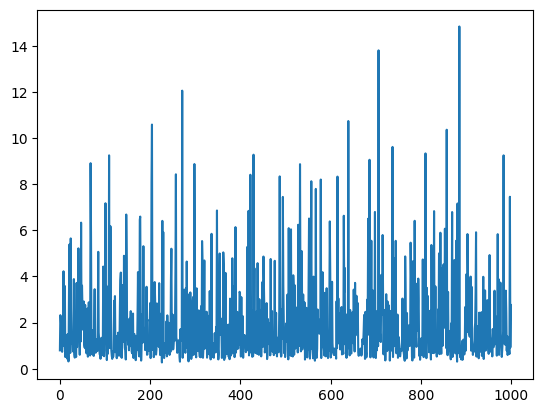

In [101]:
torch.manual_seed(42)
net = Network([1, 1, 1])

# X = torch.sigmoid(torch.randn(1))
X = torch.tensor([1.0])
epochs = 1000
lr = 0.00001
steps = 20

errs = []

for epoch in range(epochs):
    error = 0
    for x in X:
        net(x.unsqueeze(0), lr=lr, steps=steps)
        error += net.error()
    errs.append(error/len(X))

print("Error: ", error)
plt.plot(errs)

        



IndexError: too many indices for tensor of dimension 1